# Kevin Zakes - Animating NBA play-by-play data  

### Background:  The intent of this project is to familiarize myself with the NBA play-by-play tracking data that is currently available.  It borrows heavily from methods outlined by James Curley at Columbia (http://curleylab.psych.columbia.edu/nba.html), although there were numerous instances where I had to modify his code or look elsewhere for source files in order to generate the animation for the desired game and situation.  Additionally, the source data that I was able to find on Github had a strange quirk with the player coordinates which I was able to address and fix.

### In the 2015-16 NBA season, the Golden State Warriors set an NBA record with 73 regular season wins.  While primarily known as an offensive powerhouse, they also proved to be a formidable opponent on the defensive end of the court.  On defense, they often used a "switch everything" strategy, where they would combat screens by swiftly switching defenders when a screen is set. Many of the Warriors players are very quick and active on the defensive end, and their defensive strategy often forced the offense into a quick decision, sometimes leading to a turnover or poor offensive execution.  However, this strategy can backfire when the switches are not executed properly.  

### A play was examined from the game on 2015 Christams day game between the Warriors and the Cleveland Cavaliers.  In this play, LeBron James starts out with the ball with Andre Iguodala guarding him.  Initially, Kevin Love sets a high screen for James on Iguodala, and Love's defender Draymond Green switches onto James.  Next, Matthew Dellavadova comes in from the left side and sets another screen for James.  The ensuing switch leads to Stephen Curry showing to cut off James from turning the corner.  Next, instead of staying on James, Curry quickly runs back towards Dellavadova.  Meanwhile, Dellavadova is (possibly illegally) maintaining his screen on Green.  The resulting momentary confusion about who is picking up LeBron is all he needs in order to drive down the left side of the paint for an easy basket.  

### Video footage for this play can be viewed at http://stats.nba.com/events/#!/?flag=1&GameID=0021500438&GameEventID=493&Season=2015-16&title=James%20%20Driving%20Dunk%20(22%20PTS)&sct=plot

### This play forshadowed a strategy that Cleveland would employ again a few months later in the 2016 NBA Finals - executing a series of screens designed to get Curry defending LeBron (or Kyrie Irving) on the wing or at the top of the key, and attacking Golden State's defense from there.  In fact, a similar play was executed in the final minute of game seven of the Finals.  In that situation, instead of driving to the hoop, Irving hit an iconic 3 pointer after Curry switched onto him.  That play, drawn up during a timeout moments before, proved to be the defining offensive play of Cleveland's championship. 

### Load required libraries:

In [2]:
setwd("/Users/zakesk/basketball")

In [5]:
library(RCurl)
library(jsonlite)
library(dplyr)
library(sp)
library(ggplot2)
library(data.table)
library(gganimate)

### Many of the functions for this project were sourced from the following location:

In [3]:
source("https://raw.githubusercontent.com/jalapic/nba/master/playbyplayfunctions.R")

### The SportVu player tracking data for various NBA games during the first half of the 2015-2016 season was found on Github.  The SportVu data for this particular game was downloaded from the following site:   https://github.com/linouk23/NBA-Player-Movements/blob/master/data/2016.NBA.Raw.SportVU.Game.Logs/12.25.2015.CLE.at.GSW.7z


### Unpacking the .7z file resulted in a JSON file, which was run through a sourced function ("sportvu_convert_json") that receives the file and transforms it into a data frame for the analysis.


In [4]:
all.movements <- sportvu_convert_json("0021500438.json")

Warning message in FUN(X[[i]], ...):
“NAs introduced by coercion”

### The resulting variable has 13 variables, with 2,562,242 observations:

In [6]:
str(all.movements)

'data.frame':	2562242 obs. of  13 variables:
 $ player_id : chr  "201567" "201567" "201567" "201567" ...
 $ lastname  : chr  "Love" "Love" "Love" "Love" ...
 $ firstname : chr  "Kevin" "Kevin" "Kevin" "Kevin" ...
 $ jersey    : chr  "0" "0" "0" "0" ...
 $ position  : chr  "F" "F" "F" "F" ...
 $ team_id   : num  1.61e+09 1.61e+09 1.61e+09 1.61e+09 1.61e+09 ...
 $ x_loc     : num  36.7 36.7 36.7 36.7 36.7 ...
 $ y_loc     : num  24.8 24.8 24.8 24.8 24.8 ...
 $ radius    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ game_clock: num  720 720 720 720 720 720 720 720 720 720 ...
 $ shot_clock: num  24 24 24 24 24 24 24 24 24 24 ...
 $ quarter   : num  1 1 1 1 1 1 1 1 1 1 ...
 $ event.id  : num  1 2 2 1 1 2 1 2 1 2 ...


### Initial inspection of the data frame shows that the data is properly formatted:

In [7]:
head(all.movements)

player_id,lastname,firstname,jersey,position,team_id,x_loc,y_loc,radius,game_clock,shot_clock,quarter,event.id
201567,Love,Kevin,0,F,1610612739,36.68877,24.80455,0,720,24,1,1
201567,Love,Kevin,0,F,1610612739,36.68877,24.80455,0,720,24,1,2
201567,Love,Kevin,0,F,1610612739,36.69438,24.79715,0,720,24,1,2
201567,Love,Kevin,0,F,1610612739,36.69438,24.79715,0,720,24,1,1
201567,Love,Kevin,0,F,1610612739,36.70210,24.78821,0,720,24,1,1
201567,Love,Kevin,0,F,1610612739,36.70210,24.78821,0,720,24,1,2


### However, when initially running the animation with this data, the "left-to-right" action was reverse mirroring the  television footage of the play.  For instance, LeBron drives to the left on the actual play, but the animation shows him driving to the right.  For some reason, the "y-loc" variable contained data that was reversed.  Examining the "y-loc" data, it appears the court y-coordinates range from 0-50, with 25 being the middle of the court (i.e. where the nail is located on the free throw lines).  Values outside this range represent a player being out of bounds.

In [8]:
max(all.movements$y_loc)
min(all.movements$y_loc)

max(all.movements$x_loc)
min(all.movements$x_loc)

[1] 52.81007

[1] -2.81185

[1] 101.718

[1] -5.27795

### Transforming the "y_loc" column in the data frame with the following function fixed the issue:

In [9]:
# mirror y_loc coordinates
all.movements$y_loc <- 50 - all.movements$y_loc

In [10]:
# after adjusting with reflection point 
head(all.movements)

player_id,lastname,firstname,jersey,position,team_id,x_loc,y_loc,radius,game_clock,shot_clock,quarter,event.id
201567,Love,Kevin,0,F,1610612739,36.68877,25.19545,0,720,24,1,1
201567,Love,Kevin,0,F,1610612739,36.68877,25.19545,0,720,24,1,2
201567,Love,Kevin,0,F,1610612739,36.69438,25.20285,0,720,24,1,2
201567,Love,Kevin,0,F,1610612739,36.69438,25.20285,0,720,24,1,1
201567,Love,Kevin,0,F,1610612739,36.70210,25.21179,0,720,24,1,1
201567,Love,Kevin,0,F,1610612739,36.70210,25.21179,0,720,24,1,2


### The NBA play-by-play data was taken from the following website: http://stats.nba.com/stats/playbyplayv2?EndPeriod=10&EndRange=55800&GameID=0021500438&RangeType=2&StartPeriod=1&StartRange=0

### There were issues with directly importing the play-by-play data into R from the nba.com website, so the contents of the site were saved in a JSON file, and then loaded into a dataframe.

In [11]:
  the.data.file<-fromJSON("playbyplayxmas2015.json")
  test <-the.data.file$resultSets$rowSet
  test2 <- test[[1]]
  pbp <- data.frame(test2)
  coltest <- the.data.file$resultSets$headers
  colnames(pbp) <- coltest[[1]]

### A quick examination shows the "pbp" data frame appears to be propertly formatted:

In [12]:
head(pbp)

GAME_ID,EVENTNUM,EVENTMSGTYPE,EVENTMSGACTIONTYPE,PERIOD,WCTIMESTRING,PCTIMESTRING,HOMEDESCRIPTION,NEUTRALDESCRIPTION,VISITORDESCRIPTION,⋯,PLAYER2_TEAM_CITY,PLAYER2_TEAM_NICKNAME,PLAYER2_TEAM_ABBREVIATION,PERSON3TYPE,PLAYER3_ID,PLAYER3_NAME,PLAYER3_TEAM_ID,PLAYER3_TEAM_CITY,PLAYER3_TEAM_NICKNAME,PLAYER3_TEAM_ABBREVIATION
0021500438,0,12,0,1,5:21 PM,12:00,NA,NA,NA,⋯,NA,NA,NA,0,0,NA,NA,NA,NA,NA
0021500438,1,10,0,1,5:21 PM,12:00,Jump Ball Bogut vs. Mozgov: Tip to Love,NA,NA,⋯,Cleveland,Cavaliers,CLE,5,201567,Kevin Love,1610612739,Cleveland,Cavaliers,CLE
0021500438,2,5,39,1,5:21 PM,11:44,NA,NA,Mozgov Step Out of Bounds Turnover (P1.T1),⋯,NA,NA,NA,1,0,NA,NA,NA,NA,NA
0021500438,3,5,2,1,5:22 PM,11:25,Rush Lost Ball Turnover (P1.T1),NA,James STEAL (1 STL),⋯,Cleveland,Cavaliers,CLE,0,0,NA,NA,NA,NA,NA
0021500438,4,2,85,1,5:22 PM,11:03,NA,NA,MISS Love 4' Turnaround Bank Shot,⋯,NA,NA,NA,0,0,NA,NA,NA,NA,NA
0021500438,5,4,0,1,5:22 PM,11:03,Thompson REBOUND (Off:0 Def:1),NA,NA,⋯,NA,NA,NA,0,0,NA,NA,NA,NA,NA


### The next step is to remove data not used in the animation:

In [13]:
pbp <- pbp[-1,] #remove first row
colnames(pbp)[2] <- c('event.id') # used to merge on all.movements dataframe
pbp0 <- pbp %>% select (event.id,EVENTMSGTYPE,EVENTMSGACTIONTYPE,SCORE)
pbp0$event.id <- as.numeric(levels(pbp0$event.id))[pbp0$event.id]
head(pbp0)

,event.id,EVENTMSGTYPE,EVENTMSGACTIONTYPE,SCORE
2,1,10,0,NA
3,2,5,39,NA
4,3,5,2,NA
5,4,2,85,NA
6,5,4,0,NA
7,6,2,1,NA


In [14]:
tail(pbp0)

,event.id,EVENTMSGTYPE,EVENTMSGACTIONTYPE,SCORE
486,557,3,11,83 - 88
487,559,3,12,83 - 89
488,561,9,2,NA
489,562,2,1,NA
490,563,4,0,NA
491,564,13,0,83 - 89


### Examining the play-by-play log on the nba.com website, the event to be animated is 493.  A quick look at the score for this event verifies this is the correct play:

In [15]:
pbp0[pbp0$event.id==493,]

,event.id,EVENTMSGTYPE,EVENTMSGACTIONTYPE,SCORE
434,493,1,49,73 - 81


### The two data frames are merged together by event.id, and the dimensions of this dataframe is rather large.

In [16]:
all.movements <- merge(x = all.movements, y = pbp0, by = "event.id", all.x = TRUE)
dim(all.movements)

[1] 2562242      16

### The id493 variable is then created by selecting the appropriate rows from the larger dataframe:

In [17]:
id493 <- all.movements[which(all.movements$event.id == 493),]
dim(id493)

[1] 7150   16

In [18]:
head(id493)

,event.id,player_id,lastname,firstname,jersey,position,team_id,x_loc,y_loc,radius,game_clock,shot_clock,quarter,EVENTMSGTYPE,EVENTMSGACTIONTYPE,SCORE
2316307,493,203521,Dellavedova,Matthew,8,G,1610612739,67.30526,25.31841,0,228.51,15.70,4,1,49,73 - 81
2316308,493,202691,Thompson,Klay,11,G,1610612744,68.37791,40.02746,0,225.96,24.00,4,1,49,73 - 81
2316309,493,201567,Love,Kevin,0,F,1610612739,88.76534,22.06867,0,227.50,24.00,4,1,49,73 - 81
2316310,493,2738,Iguodala,Andre,9,G-F,1610612744,73.23404,32.29334,0,228.26,15.49,4,1,49,73 - 81
2316311,493,2733,Livingston,Shaun,34,G,1610612744,83.93413,27.38557,0,228.30,15.52,4,1,49,73 - 81
2316312,493,201567,Love,Kevin,0,F,1610612739,93.73214,20.42830,0,224.42,24.00,4,1,49,73 - 81



### Examining the "game_clock" variable shows the time range for event 493:

In [19]:
max(id493$game_clock)
min(id493$game_clock)

[1] 228.71

[1] 202.47

### The variable "clock_freeze" is created to show the initial state of the play before the screen is set which leads to Curry jumping out on LeBron.  This occurs at the time 212.13.

In [20]:
clock_freeze <- 212.13

### A data frame is created showing the coordinates of each player and the ball at this time:

In [21]:
playerdf <- player_position1(df=id493, eventid=493,gameclock=clock_freeze) 
playerdf

ID,X,Y,jersey
1610612739,7.66411,1.93193,4
1610612739,8.34234,47.40137,2
1610612744,9.54603,12.62083,34
1610612739,11.50524,37.21895,0
1610612744,13.39608,32.93889,9
1610612744,13.49261,40.16264,11
1610612744,24.17604,12.42015,30
1610612739,27.06493,6.44722,8
1610612744,28.03426,23.90462,23
1610612739,37.72973,23.37479,23


### Similarly, a data frame is created for the coordinates of the ball:

In [22]:
ballposdf <- ball_position1(df=id493, eventid=493, gameclock=clock_freeze)
ballposdf

ID,X,Y,jersey
NA,37.34173,21.27249,NA


### The sourced function "fullcourt" creates the visualization of this moment by plotting the player's locations, their jersey numbers and the ball location on a basketball court:

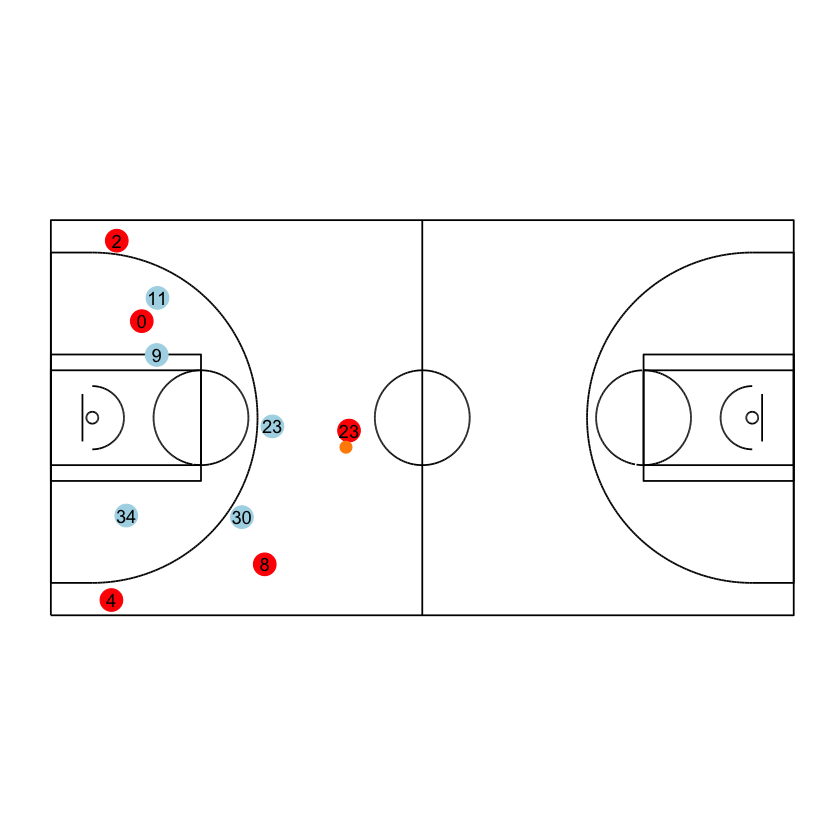

In [23]:
fullcourt() + 
  geom_point(data=playerdf,aes(x=X,y=Y,group=ID,color=factor(ID)),size=6) +       #players
  geom_text(data=playerdf,aes(x=X,y=Y,group=ID,label=jersey),color='black') +     #jersey number
  geom_point(data=ballposdf,aes(x=X,y=Y),color='darkorange',size=3) +              #ball
  scale_color_manual(values=c("red","lightblue")) +
  scale_fill_manual(values=c("red","lightblue")) +
  theme(legend.position="none")


## The Cleveland Cavaliers (red) players on the above image are: LeBron James (#23), Kevin Love (#0), Matthew Dellavadova (#8), Iman Shumpert (#4), and Kyrie Irving (#2).  The Golden State Warriors (blue) players are Draymond Green (#23), Stephen Curry (#30), Andre Iguodala (#9), Shaun Livingston (#34) and Klay Thompson (#11). 

### In order for the animation to work properly, the "clocktimes" variable is created.  This variable extracts the unique "game_clock" values and stores them in descending order:

In [24]:
clocktimes = rev(sort(unique(id493$game_clock)))

### The dataframe "fulldf" is created, then populated by looping through the "clocktimes" and storing the position of the players and the position of the ball at each unique point in time. 

In [27]:
fulldf=list()

 for(i in seq_along(clocktimes)){
  
  dplayer <- player_position1(df=id493, 493,clocktimes[i]) #Gets positions of players
  ballpos <- ball_position1(df=id493, 493,clocktimes[i])  #Gets position of ball
  dplayer$valx = 'player'
  ballpos$valx  = 'ball'
  fulldf[[i]] = rbind(dplayer,ballpos)
}

 length(fulldf)  

[1] 650

### The time element is then added to the dataframe: 

In [28]:
 fulldf = Map(cbind,fulldf,timebin=1:length(fulldf)) 

### Another data frame is created that eliminates the time before and after Cleveland is on offense:


In [29]:
playdf = data.table::rbindlist(fulldf)
playdf2 = playdf %>% filter(timebin>94) %>% filter(timebin<570)

### The "fullcourt" function is called again, although now it uses the specified timebins to create seperate images for each moment captured in the SportVu data:

In [31]:
### original code
p = fullcourt() + 
  geom_point(data=playdf2 %>% filter(valx=="player"),aes(x=X,y=Y,group=ID,color=factor(ID),frame=timebin),size=6) +
  geom_text(data=playdf2 %>% filter(valx=="player"),aes(x=X,y=Y,group=ID,frame=timebin,label=jersey),color='black') +
  geom_point(data=playdf2 %>% filter(valx=="ball"),aes(x=X,y=Y,frame=timebin),color='darkorange',size=3) +
  scale_color_manual(values=c("red","lightblue")) +
  scale_fill_manual(values=c("red","lightblue")) +
  theme(legend.position="none")

Warning message:
“Ignoring unknown aesthetics: frame”Warning message:
“Ignoring unknown aesthetics: frame”Warning message:
“Ignoring unknown aesthetics: frame”

### Finally, the dynamic visualization is created using "gganimate" and saves it as a gif file.  The file "xmas_play_lebron_curry.gif" is located at https://github.com/zakesk/kings/tree/master/Project2 

In [32]:
gganimate(p, "xmas_play_lebron_curry.gif", title_frame =F, ani.width = 600, ani.height = 450, interval=0.1)  

Executing: 
convert -loop 0 -delay 10 Rplot1.png Rplot2.png Rplot3.png Rplot4.png
    Rplot5.png Rplot6.png Rplot7.png Rplot8.png Rplot9.png Rplot10.png
    Rplot11.png Rplot12.png Rplot13.png Rplot14.png Rplot15.png
    Rplot16.png Rplot17.png Rplot18.png Rplot19.png Rplot20.png
    Rplot21.png Rplot22.png Rplot23.png Rplot24.png Rplot25.png
    Rplot26.png Rplot27.png Rplot28.png Rplot29.png Rplot30.png
    Rplot31.png Rplot32.png Rplot33.png Rplot34.png Rplot35.png
    Rplot36.png Rplot37.png Rplot38.png Rplot39.png Rplot40.png
    Rplot41.png Rplot42.png Rplot43.png Rplot44.png Rplot45.png
    Rplot46.png Rplot47.png Rplot48.png Rplot49.png Rplot50.png
    Rplot51.png Rplot52.png Rplot53.png Rplot54.png Rplot55.png
    Rplot56.png Rplot57.png Rplot58.png Rplot59.png Rplot60.png
    Rplot61.png Rplot62.png Rplot63.png Rplot64.png Rplot65.png
    Rplot66.png Rplot67.png Rplot68.png Rplot69.png Rplot70.png
    Rplot71.png Rplot72.png Rplot73.png Rplot74.png Rplot75.png
    Rplot76.png